In [114]:
# Library
library(dplyr)
library(tidyverse)
library(sf)
library(sparr)
library(spatstat)

In [115]:
# load area(Daejeon grid)
DJ_area = read_sf('data/CENSUS/grid_DJ_100M.gpkg')
Whole_area = read_sf('data/CENSUS/grid_100M.gpkg') # 대전 + 세종 그리드

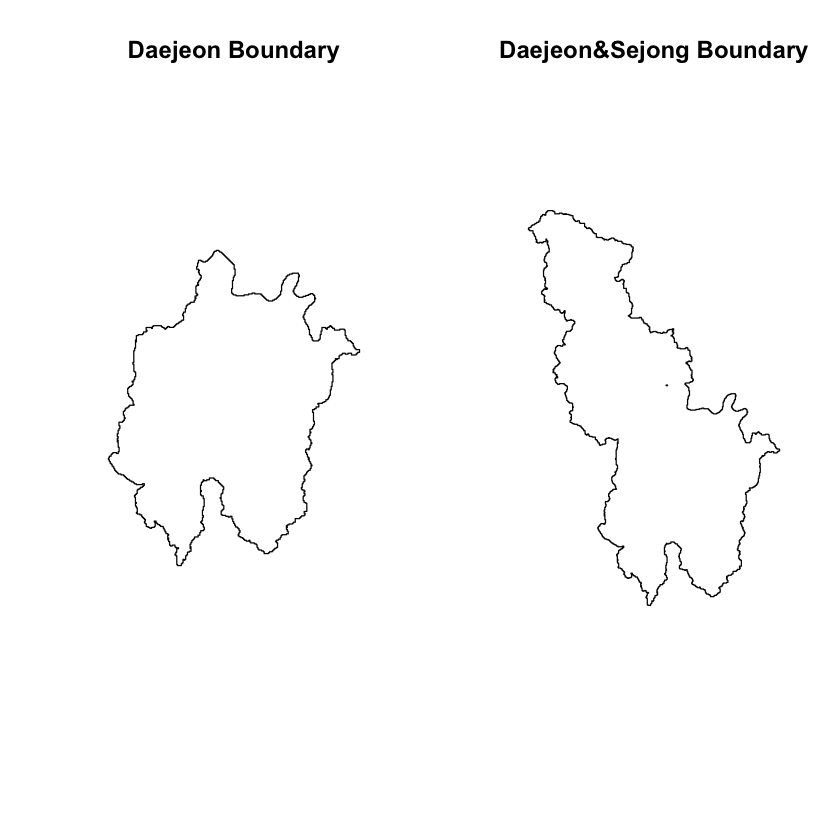

In [116]:
# get boundary of area
par(mfrow=c(1,2))
boundary_DJ = st_union(DJ_area$geom)
boundary_DJSJ = st_union(Whole_area$geom)
plot(boundary_DJ, bg='white', main = 'Daejeon Boundary')
plot(boundary_DJSJ, bg='white', main = 'Daejeon&Sejong Boundary')

In [123]:
## read crime data
df_crime_DJ = read_csv('STKDE/data_100M.csv') %>% unique()
# df_crime_DJSJ = read_csv('STKDE/data_100M_DJSJ.csv')
# df_crime_DJ_full = read_csv('STKDE/data_100M_DJ_to22_2h.csv')
df_crime_1K = read_csv('STKDE/data.csv') %>% unique()

Rows: 2819 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): geometry
dbl  (3): T, X, Y
dttm (1): RECV_CPLT_DM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2819 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): geometry
dbl  (3): T, X, Y
dttm (1): RECV_CPLT_DM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [131]:
crime_DJ <- ppp(x=df_crime_DJ$X, y=df_crime_DJ$Y, window = as.owin(boundary_DJ), marks = df_crime_DJ$T)
# # crime_DJSJ <- ppp(x=df_crime_DJSJ$X, y=df_crime_DJSJ$Y, window = as.owin(boundary_DJSJ), marks = df_crime_DJSJ$T)
# crime_DJ_full <- ppp(x=df_crime_DJ_full$X, y=df_crime_DJ_full$Y, window = as.owin(boundary_DJ), marks = df_crime_DJ_full$T)
# crime_1K <- ppp(x=df_crime_1K$X, y=df_crime_1K$Y, window = as.owin(boundary_DJ), marks = df_crime_1K$T)

Warning message:
“48 points were rejected as lying outside the specified window”
Warning message:
“data contain duplicated points”


## Oversmoothing bandwidth

In [106]:
Hlam_os_DJ_full <- OS.spattemp(crime_DJ_full)
Hlam_os_DJ_full

h   lambda 
445.0858 742.4428

In [133]:
OS.spattemp(crime_DJ)

h    lambda 
743.74656  25.38702

In [107]:
# hlam_os_DJ <- OS.spattemp(crime_DJ) # oversmoothing bd for crime data in Daejeon
# hlam_os_DJSJ <- OS.spattemp(crime_DJSJ) # oversmoothing bd for crime data in Daejeon/Sejong
# hlam_os_DJ
# hlam_os_DJSJ

## Likelihood CV selector
$$
h_{LIK} = \arg\max_h [LIK(h|\mathbf{X})]
$$
where
$$
LIK(h|\mathbf{X}) = {1\over n}\sum_{i=1}^n\log[\tilde f_h (x_i|\mathbf{X}_{-i})]
$$

In [117]:
# hlam_DJ_full <- LIK.spattemp(crime_DJ_full)
# hlam_DJ_full

In [134]:
# likelihood cv selector
hlam_DJ <- LIK.spattemp(crime_DJ)
# hlam_DJSJ <- LIK.spattemp(crime_DJSJ)

h = 743.7466; lambda = 7.085016 
h = 818.1212; lambda = 7.085016 
h = 743.7466; lambda = 81.45967 
h = 669.3719; lambda = 81.45967 
h = 594.9973; lambda = 118.647 
h = 594.9973; lambda = 193.0217 
h = 632.1846; lambda = 146.5375 
h = 446.2479; lambda = 230.209 
h = 297.4986; lambda = 304.5836 
h = 297.4986; lambda = 230.209 
h = 148.7493; lambda = 248.8026 
h = 446.2479; lambda = 193.0217 
h = 148.7493; lambda = 341.771 
h = 371.8733; lambda = 230.209 
h = 223.124; lambda = 304.5836 
h = 334.686; lambda = 248.8026 
h = 260.3113; lambda = 285.99 
h = 316.0923; lambda = 258.0995 
h = 278.905; lambda = 276.6931 
h = 306.7955; lambda = 262.7479 
h = 288.2018; lambda = 272.0447 
h = 302.147; lambda = 265.0721 
h = 302.147; lambda = 190.6974 
h = 304.4712; lambda = 133.7544 
h = 299.8228; lambda = 98.89123 
h = 301.566; lambda = 223.5269 
h = 300.4039; lambda = 140.4365 
h = 299.8228; lambda = 98.89123 
h = 307.3765; lambda = 43.98182 
h = 299.9681; lambda = 183.6522 
h = 304.907; lambda = 9

In [135]:
# result
hlam_DJ
# hlam_DJSJ
# hlam_DJ_full

h   lambda 
299.6484 142.9852

## Density Estimation
with LooCV optimal bandwidth

In [95]:
tmin = crime_DJ_full$T %>% min()
tmax = crime_DJ_full$T %>% max()
tlim = c(tmin-4, tmax+4)

[1] 747

In [96]:
f.crime_DJ_full <- spattemp.density(
    crime_DJ_full, h=hlam_DJ_full[1], lambda=hlam_DJ_full[2], tlim = c(-370,750)
)

Calculating trivariate smooth...
Done.

Edge-correcting...
Done.

Conditioning on time...
Done.



In [139]:
# STKDE and oversmoothing STKDE
f.crime_DJ <- spattemp.density(
    crime_DJ, h=hlam_os_DJ[1], lambda=hlam_os_DJ[2], tlim = c(-10,370)
)
# f.crime_DJSJ <- spattemp.density(
#     crime_DJSJ, h=hlam_DJSJ[1], lambda=14, tlim = c(-10,370)
# )

Calculating trivariate smooth...
Done.

Edge-correcting...
Done.

Conditioning on time...
Done.



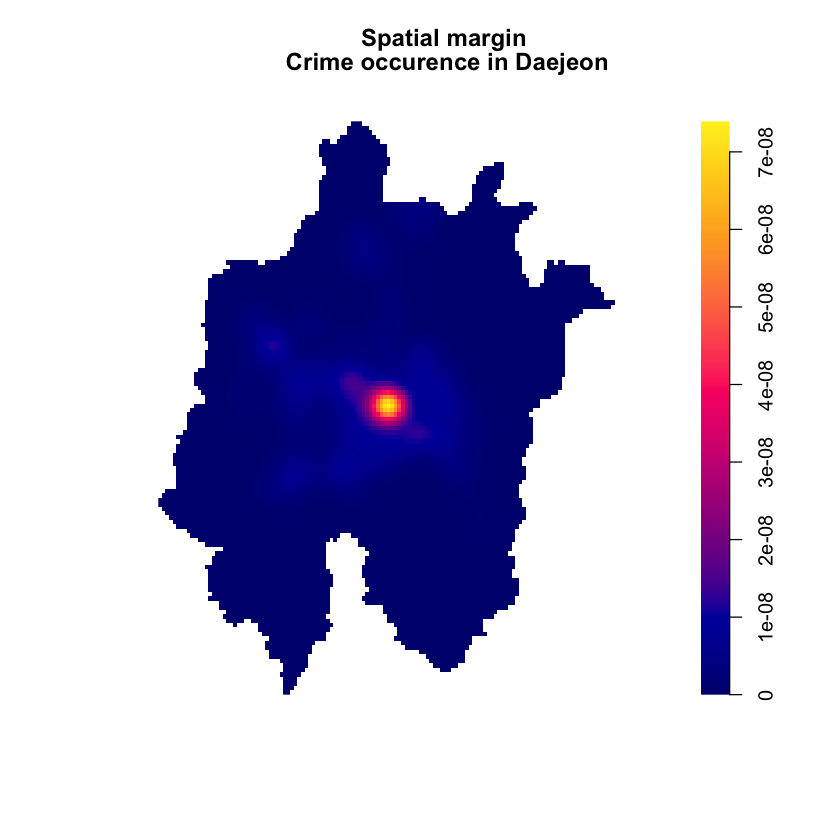

In [140]:
## spatial margin plot
# par(mfrow=c(1,3))
plot(f.crime_DJ$spatial.z, box=FALSE, main="Spatial margin\n Crime occurence in Daejeon", bg='white')
# plot(f.crime_DJSJ$spatial.z, box=FALSE, main="Spatial margin\n Crime occurence in Daejeon&Sejong", bg='white')
# plot(f.crime_DJ_full$spatial.z, box=FALSE, main="Spatial margin\n Crime occurence in Daejeon&Sejong", bg='white')


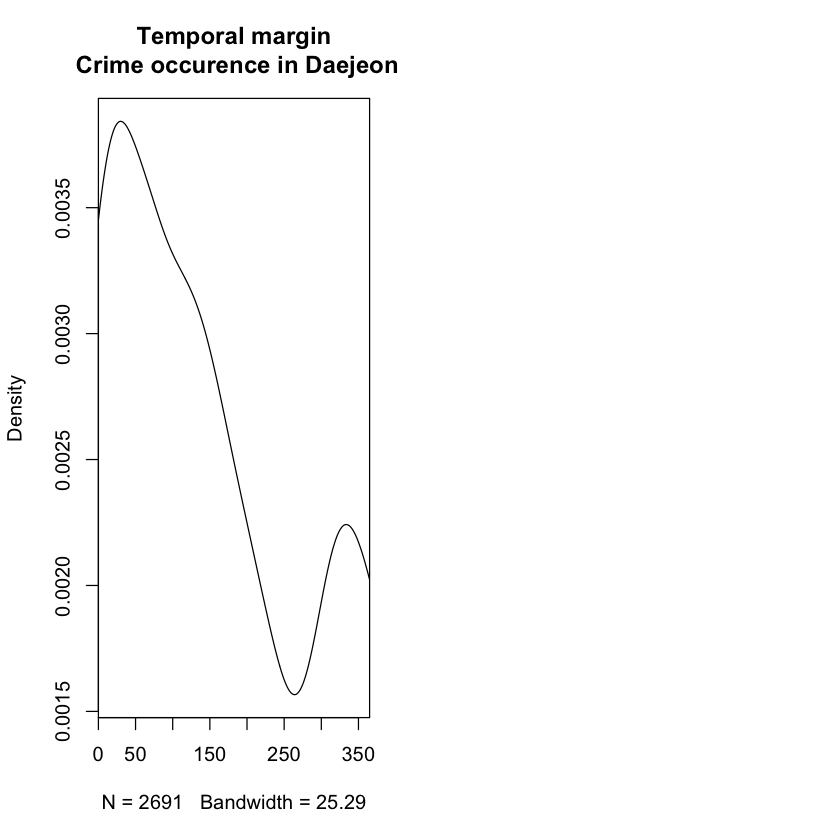

In [141]:
# Temporal Margin plot
par(mfrow=c(1,2))
plot(f.crime_DJ$temporal.z, xlim=c(0,365), xaxs="i", main="Temporal margin\n Crime occurence in Daejeon", bg='white')
# plot(f.crime_DJSJ$temporal.z, xlim=c(0,365), xaxs="i", main="Temporal margin\n Crime occurence in Daejeon&Sejong", bg='white')

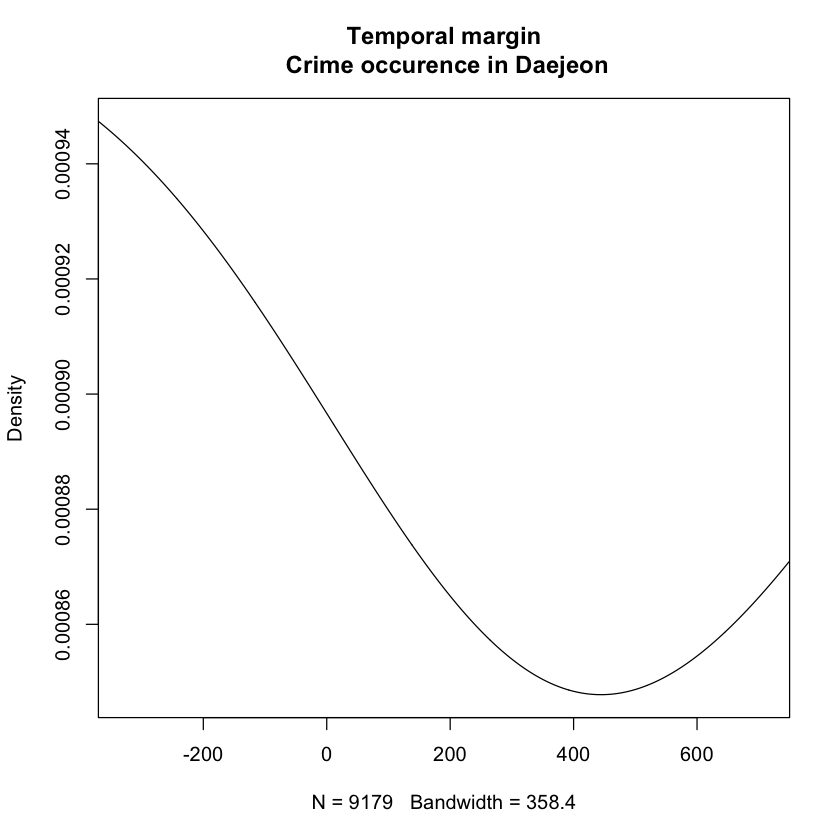

In [98]:
plot(f.crime_DJ_full$temporal.z, xlim=c(-370,750), xaxs="i", main="Temporal margin\n Crime occurence in Daejeon", bg='white')